<a href="https://colab.research.google.com/github/Brun0oO/Brun0oO.github.io/blob/master/Colab/colab_fastapi_localtunnel_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is used in conjunction with the following project: https://github.com/Brun0oO/defold-colab. It serves as a proof of concept to demonstrate a kind of a communication protocol between a Google Colab notebook and a Defold application on its smartphone.

# Install LocalTunnel service

Localtunnel allows you to easily share a web service on your local development machine without messing with DNS and firewall settings.

In [ ]:
import logging
import os

if os.path.exists("/tools/node/") == False:
  !apt install nodejs
  !npm i -g npm
else:
  !echo "nodejs Already installed"

nodejs Already installed


In [ ]:
from IPython.display import HTML, clear_output
if os.path.exists("/tools/node/lib/node_modules/localtunnel/") == False:
  !npm install -g localtunnel
  clear_output(wait=True)
  !echo "succeeded"
else:
  !echo "localtunnel Already installed"

succeeded


# **Install Required python library**

In [ ]:
!pip install fastapi nest-asyncio uvicorn python-multipart qrcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 5.9 MB/s eta 0:00:00
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=0b916bc70d56b8ed006122f2ae4af3a6a53ef3314dac6d243f7418b751bf88e8
  Stored in directory: /root/.cache/pip/wheels/9e/fc/1c/cf980e6413d3ee8e70cd8f39e2366b0f487e3e221aeb452eb0
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-an

# **Simple FastAPI Server**

The following code launches a fastapi server delevering RESTful APIs available through a tunnel (provided by the localtunnel service). 

tunnel subprocess pid :  688
Online at https://3e0c4dbd80d14465b8931709c007371b.localtunnel.me


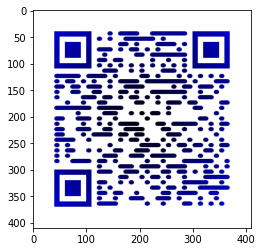

INFO:     Started server process [471]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "GET /ping HTTP/1.1" 200 OK
INFO:     82.64.30.44:0 - "G

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [471]


In [ ]:
import subprocess
import uuid

from fastapi import FastAPI, UploadFile, File, Form, HTTPException
from fastapi.responses import HTMLResponse, RedirectResponse

import nest_asyncio
import uvicorn
import io

import pathlib
from PIL import Image

import qrcode
from qrcode.image.styledpil import StyledPilImage
from qrcode.image.styles.moduledrawers import HorizontalBarsDrawer
from qrcode.image.styles.colormasks import RadialGradiantColorMask

import matplotlib.pyplot as plt
from time import sleep

# Tunnel configuration
subdomain = uuid.uuid4().hex
port = 8000
cmd = "lt -s %s -p %s" % (subdomain, port)
public_url = "https://%s.localtunnel.me" % subdomain

# QRCode creation
def createQRCode(text):
  qr = qrcode.QRCode(
      version=1,
      error_correction=qrcode.constants.ERROR_CORRECT_L,
      box_size=10,
      border=4,
  )
  qr.add_data(text)

  result = qr.make_image(image_factory=StyledPilImage, module_drawer=HorizontalBarsDrawer(), color_mask=RadialGradiantColorMask())

  return result

# Processing of the image provided by call to the dedicated web service
def processImage(img):
  # here your complex processing operation 
  # well, in this basic example ;o)
  # I just chose to return the dimensions of the image
  # At the end, remember to return your result using an array containing 
  # one or more basic python data (i.e. which can be serialized in json)
  result = [img.width, img.height]
  return result


# Web Server implementation
# 4 RESTFul APIs are available :
# [server_url]/             => display information returned by the [server_url]/docs api
# [server_url]/docs         => return information about each available api
# [server_url]/ping         => use by the defold application to check if the server is still available
# [server_url]/analyze      => an image is send as parameter, the defold application waits for a result

app = FastAPI()

@app.get('/', response_class=HTMLResponse)
async def home():
  result = """
<h1>FastAPI with Colab is great!</h1>
<br>
<p>Some useful links:</p>
<ul>
  <li><a href="%s/docs">automatic interactive API documentation</a></li>
</ul>
  """ % (public_url)
  return result

@app.post("/analyze")
async def analyze(image: UploadFile = File(...)):
  extension = pathlib.Path(image.filename).suffix.lower()
  if not(extension in ['.png', '.jpg', '.jpeg']):
    raise HTTPException(status_code=400, detail="bad parameter, waiting for a .png or .jpg filename !")

  contents = await image.read()
  img = Image.open(io.BytesIO(contents))
  result = processImage(img)
  return {'msg': 'success', 'result': result}


@app.get("/ping")
async def ping():
  return { 'msg': 'success', 'result': 'pong'}

@app.get("/docs")
async def docs_redirect():
  response = RedirectResponse(url='/docs')
  return response



# Running...
# > Start the tunnel in a background process
tunnel_subprocess = subprocess.Popen(cmd, shell=True)
print("Tunnel subprocess pid : ", tunnel_subprocess.pid)

# > Serve the web app
#   > Display the url using a qrcode
print("Online at %s" % public_url)
qrcode = createQRCode(public_url)
plt.imshow(qrcode)
plt.show()
sleep(0.5)
#   > Launch the http server
nest_asyncio.apply() #need this patch otherwise got "RuntimeError: This event loop is already running"
uvicorn.run(app, port=port)